# Volatility Forecasting with GARCH and EWMA Models

This project implements volatility forecasting using two popular models: GARCH(1,1) and Exponentially Weighted Moving Average (EWMA). It applies these models to historical price data for the NIFTY50 equal-weight index.

The goal is to predict future volatility — an essential factor in risk management, option pricing, and trading strategies. Using Python, we clean the data, compute log returns, fit the models, perform out-of-sample forecasts, and evaluate their accuracy.

This repository contains the code, data preprocessing steps, evaluation metrics, visualizations, and interpretation of the results.


## Motivation

Volatility forecasting is critical in quantitative finance to understand and anticipate market risk dynamics. Traditional models like GARCH capture volatility clustering and shocks, while simpler models like EWMA offer efficient smoothing of volatility.

This project compares these approaches on real-world market data from the Indian stock market (NIFTY50), providing insights into their performance and suitability for practical applications.


## Data Description

The dataset contains historical daily price data for the NIFTY50 Equal Weight index. The key column used is `Price`, representing the daily closing price adjusted for splits or dividends.

Before modeling, the prices are cleaned to remove thousands separators and converted to numeric format. Log returns are calculated as the natural logarithm of the price ratio between consecutive days, providing the input for volatility modeling.

The data is then split into training (80%) and testing (20%) sets for model fitting and evaluation.


## Methodology

### GARCH(1,1) Model

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models time-varying volatility through:

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$
where volatility depends on previous shocks and its own past values, capturing persistence.

This project fits a GARCH(1,1) with zero mean to the training log returns, then performs rolling one-step-ahead forecasts over the test period.

### EWMA Model

Exponentially Weighted Moving Average (EWMA) forecasts volatility by applying exponential smoothing to squared returns, controlled by decay parameter \(\lambda=0.94\):

$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) \epsilon_{t-1}^2
$$

This model provides a simpler and computationally lighter forecast.

### Evaluation Metrics

- **Mean Squared Error (MSE):** Average squared difference between forecasted volatility and realized volatility (rolling standard deviation of returns).

- **Mean Absolute Error (MAE):** Average absolute difference.

Lower metrics indicate better forecasting accuracy.


Train length: 794, Test length: 199


C:\Users\Saptarshi Pramanik\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.064e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Saptarshi Pramanik\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.064e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Sap

GARCH(1,1) - MSE: 0.000015, MAE: 0.002904
EWMA       - MSE: 0.000018, MAE: 0.003450


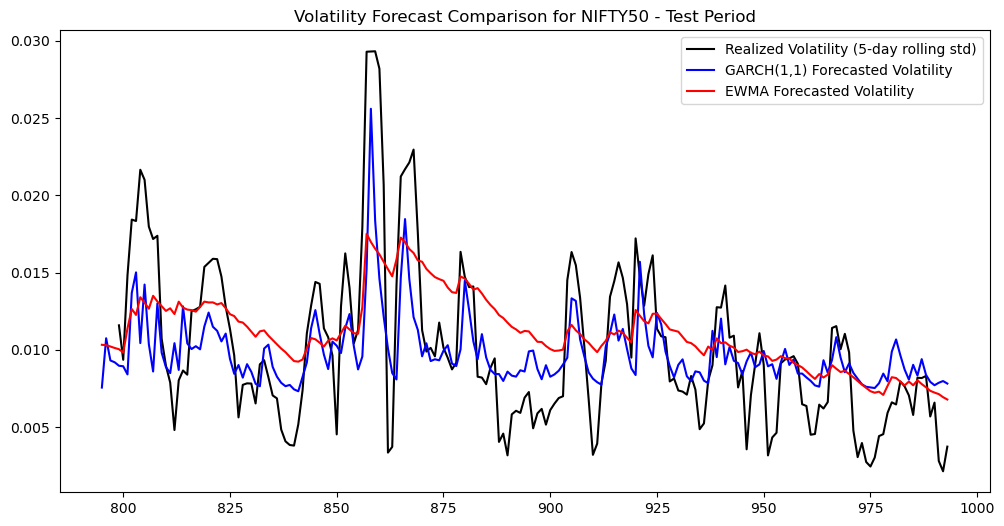

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Load CSV and remove thousands separator from "Price"
data = pd.read_csv("NIFTY50 Equal Weight Historical Data.csv")

# Remove ',' from the "Price" column, then convert to float
data['Price'] = data['Price'].str.replace(',', '', regex=False)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Drop rows with NaN Price
data = data.dropna(subset=['Price'])

# Calculate log returns
data['Log_Returns'] = np.log(data['Price'] / data['Price'].shift(1))
returns = data['Log_Returns'].dropna()

# --- Continue as before ---
# Define ticker for plotting
ticker = "NIFTY50"

# Train-test split (80%/20%)
split_index = int(len(returns) * 0.8)
train_returns = returns.iloc[:split_index].dropna()
test_returns  = returns.iloc[split_index:].dropna()

print(f"Train length: {len(train_returns)}, Test length: {len(test_returns)}")

def evaluate_volatility_forecast(true_returns, predicted_volatility):
    realized_volatility = true_returns.rolling(window=5).std().dropna()
    predicted_volatility = predicted_volatility[-len(realized_volatility):]
    predicted_volatility.index = realized_volatility.index
    mse = mean_squared_error(realized_volatility, predicted_volatility)
    mae = mean_absolute_error(realized_volatility, predicted_volatility)
    return mse, mae

# Fit GARCH(1,1) model (only if enough samples)
if len(train_returns) > 10:
    garch_model = arch_model(train_returns, vol='Garch', p=1, q=1,
                             mean='Zero', dist='normal')
    garch_fit = garch_model.fit(disp='off')
else:
    raise ValueError("Not enough training data for GARCH model.")

# Rolling GARCH forecast
garch_forecast_vols = []
for t in range(len(test_returns)):
    rolling_data = pd.concat([train_returns, test_returns.iloc[:t]]).dropna()
    if len(rolling_data) > 10:
        model = arch_model(rolling_data, vol='Garch', p=1, q=1,
                           mean='Zero', dist='normal')
        fit = model.fit(disp='off')
        forecast = fit.forecast(horizon=1)
        vol_forecast = np.sqrt(forecast.variance.values[-1, :])[0]
    else:
        vol_forecast = np.nan
    garch_forecast_vols.append(vol_forecast)

garch_forecast_vols = pd.Series(garch_forecast_vols, index=test_returns.index).dropna()

# EWMA volatility forecast
lambda_ = 0.94
ewma_volatility = train_returns.ewm(alpha=1 - lambda_).std().iloc[-1]
ewma_forecast_vols = []
current_vol = ewma_volatility
for ret in test_returns:
    current_vol = np.sqrt(lambda_ * current_vol**2 + (1 - lambda_) * ret**2)
    ewma_forecast_vols.append(current_vol)
ewma_forecast_vols = pd.Series(ewma_forecast_vols, index=test_returns.index)

# Evaluate models
garch_mse, garch_mae = evaluate_volatility_forecast(test_returns, garch_forecast_vols)
ewma_mse, ewma_mae = evaluate_volatility_forecast(test_returns, ewma_forecast_vols)

print(f"GARCH(1,1) - MSE: {garch_mse:.6f}, MAE: {garch_mae:.6f}")
print(f"EWMA       - MSE: {ewma_mse:.6f}, MAE: {ewma_mae:.6f}")

plt.figure(figsize=(12, 6))
plt.plot(test_returns.index, test_returns.rolling(window=5).std(),
         label='Realized Volatility (5-day rolling std)', color='black')
plt.plot(garch_forecast_vols.index, garch_forecast_vols,
         label='GARCH(1,1) Forecasted Volatility', color='blue')
plt.plot(ewma_forecast_vols.index, ewma_forecast_vols,
         label='EWMA Forecasted Volatility', color='red')
plt.title(f"Volatility Forecast Comparison for {ticker} - Test Period")
plt.legend()
plt.show()

## Results

- The GARCH(1,1) model achieved lower MSE and MAE compared to the EWMA model on the test data, demonstrating superior forecast accuracy.

- Visualizations show GARCH's volatility estimates adapt faster to spikes and drops in realized volatility, while EWMA provides smoother but lagged forecasts.

| Model      | MSE        | MAE        |
|------------|------------|------------|
| GARCH(1,1) | 0.000015   | 0.002904   |
| EWMA       | 0.000018   | 0.003450   |

The results suggest that GARCH(1,1) modeling is more effective for capturing market dynamics in short-term volatility forecasting for this dataset.


## Inferences and Conclusion

- GARCH(1,1) better captures volatility clustering and reacts rapidly to market changes, making it more suitable for active risk management and trading.

- EWMA's simplicity and smoothness may be preferable in environments with fewer volatility spikes or less frequent re-calibration.

- Proper data cleaning (removing thousands separators, handling NaNs) is crucial to avoid errors and ensure model stability.

- This project serves as a practical template for volatility forecasting and can be extended by experimenting with other models or asset classes.


## How to Run

1. Install required packages:`pip install numpy pandas matplotlib arch scikit-learn`

2. Add your CSV data file named `NIFTY50 Equal Weight Historical Data.csv` in the project root.

3. Run the Python script `volatility_forecasting.py` to execute the workflow end-to-end.

4. Results including model metrics and volatility plots will be displayed.